In [78]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

                            Data Loading, Cleaning and Preprocessing

In [79]:
df = pd.read_csv(r"API_SE.XPD.TOTL.GD.ZS_DS2_en_csv_v2_247510.csv")

In [80]:
Non_countries = ['Africa Eastern and Southern', 'Africa Western and Central', 'Central Europe and the Baltics', 'Channel Islands', 'Caribbean small states', 'East Asia & Pacific (excluding high income)','Early-demographic dividend','East Asia & Pacific','Europe & Central Asia (excluding high income)','Europe & Central Asia', 'Euro area','European Union','Fragile and conflict affected situations','Micronesia, Fed. Sts.', 'High income',  'Heavily indebted poor countries (HIPC)','IBRD only',
 'IDA & IBRD total',
 'IDA total',
 'IDA blend',
'Isle of Man',
'Not classified',
'Latin America & Caribbean (excluding high income)',
'Latin America & Caribbean',
 'Least developed countries: UN classification',
 'Low income',
'Lower middle income',
 'Low & middle income',
'Late-demographic dividend',
'Middle East & North Africa',
'Middle income',
'Middle East & North Africa (excluding high income)',
'OECD members',
'Other small states',
'Pre-demographic dividend',
'Pacific island small states',
 'Post-demographic dividend',
 'Sub-Saharan Africa (excluding high income)',
'Sub-Saharan Africa',
 'Small states',
'East Asia & Pacific (IDA & IBRD countries)',
 'Europe & Central Asia (IDA & IBRD countries)',
'Latin America & the Caribbean (IDA & IBRD countries)',
'Middle East & North Africa (IDA & IBRD countries)',
'South Asia (IDA & IBRD)',
 'Sub-Saharan Africa (IDA & IBRD countries)',
'Upper middle income',
'IDA only',
'North America',
'World',]

In [81]:
Countries = [c for c in df['Country Name'].values if c not in Non_countries]

In [82]:
df.set_index('Country Name', inplace = True)

In [83]:
df.drop(columns = ['Country Code', 'Indicator Name', 'Indicator Code'], inplace = True)

In [84]:
df_clean_1 = df.loc[Countries]

In [85]:
countries_less_than_50_NaN = df_clean_1.isna().mean(axis = 1) < 0.5
years_less_than_50_NaN = df_clean_1.isna().mean(axis = 0) < 0.5

In [86]:
df_clean_2 = df_clean_1.loc[countries_less_than_50_NaN, years_less_than_50_NaN]

In [87]:
countries_with_zero_NaN = df_clean_2.isna().mean(axis = 1) == 0

In [88]:
df_clean_3 = df_clean_2.loc[countries_with_zero_NaN]

In [89]:
list_of_countries = (list(df_clean_3.index))

In [90]:
df_clean_3.columns = pd.period_range(start = '1999', end = '2021', freq = 'Y')

In [91]:
df_clean_4 = df_clean_3.stack().to_frame().rename(columns = {0:'percentage of GDP'})

In [92]:
df_clean_4 = df_clean_4.rename_axis(['Country Name', 'Years'])

                                Time Series Analysis

In [100]:
def get_country(country):
    data = df_clean_4.loc[country]
    train_data = data.loc['1999':'2019']
    test_data =  data.loc['2017':'2021']
    return data, train_data, test_data, country

In [101]:
def generate_training_data(dataframe, window_size = 3):
    data = dataframe.values
    tf_data = tf.data.Dataset.from_tensor_slices(data)
    tf_data = tf_data.window(size = window_size + 1, shift = 1, drop_remainder = True)
    tf_data = tf_data.flat_map(lambda x: x.batch(window_size + 1))
    tf_data = tf_data.map(lambda y: (y[:-1], y[-1]))
    tf_data = tf_data.shuffle(buffer_size = 5)
    tf_data = tf_data.batch(1).prefetch(1)
    return tf_data

In [102]:
def generate_testing_data(dataframe, window_size = 3):
    data = dataframe.values
    tf_data = tf.data.Dataset.from_tensor_slices(data)
    tf_data = tf_data.window(size = window_size, shift = 1, drop_remainder = True)
    tf_data = tf_data.flat_map(lambda x: x.batch(window_size))
    tf_data = tf_data.batch(1).prefetch(1)
    return tf_data, dataframe.index

In [103]:
def build_model(train_data, epochs, val_data = None, window_size = 3):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
                                   tf.keras.layers.Dense(10, activation = 'relu'),
                                   tf.keras.layers.Dense(1)])
    model.compile(tf.keras.optimizers.Adam(0.001), 'mse')
    
    print(model.summary())
    
    history = model.fit(train_data, epochs = epochs, validation_data = val_data)
    
    return model, pd.DataFrame(history.history)

In [104]:
def visualize_timeseries(data, title, ax = None, style = '-', labels = None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if type(data) is tuple:
        for data_, style_ in zip(data, style):
            data_.plot(ax = ax,style = style_)
    else:
        data.plot(ax = ax)
    if labels is not None:
        ax.legend(labels)

    ax.set_xlabel('Time')
    ax.set_ylabel('% of GDP')
    ax.set_title(title)
    ax.grid()
    plt.show()
    

In [105]:
def forecast(model, periods, ts):
    data_series = ts.squeeze().iloc[-3:]
    data = list(np.squeeze(data_series.values))
    for _ in range(periods):
        input = np.expand_dims(data[-3:], axis = 0)
        output = float(np.squeeze(model.predict(input)))
        data.append(output)
    data = data[2:]
    data = pd.Series(data, index = pd.period_range('2021', freq = '1Y', periods = periods + 1))
    return data
    

In [106]:
def plot_forecast(country, periods):
    data, train_data, test_data, country_name = get_country(country)
    model = model_dict[country]
    forecast_data = forecast(model, periods, data).to_frame().rename(columns = {0:'Forecasts'})
    
    test_input, test_time =  generate_testing_data(test_data)
    test_prediction = model.predict(test_input)
    test_prediction = test_prediction[-3:]
    test_prediction = pd.Series(test_prediction[:,0], index = test_time[-3:])
    MSE = mean_squared_error(test_data.loc['2019':'2021'], test_prediction)
    MAE = mean_absolute_error(test_data.loc['2019':'2021'], test_prediction)
    MSE = np.round(MSE,2)
    MAE = np.round(MAE,2)
    
    visualize_timeseries((train_data, test_data, forecast_data), style = ('-', '-', '-'), labels = ['train', 'test', 'forecast'], title = f'{periods}-year forecast for {country} (MSE: {MSE}, MAE: {MAE})')
    print(forecast_data.iloc[1:])


C:\Users\Balogun Oladimeji\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 29.3430
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.3120 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.3241
Epoch 4/100


C:\Users\Balogun Oladimeji\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9893 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5295 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5935 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3617 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3774 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4043 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3954 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4031 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4418 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4516 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4257     
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4751 
Epoch 16/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4440 
Epoch 17/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4774 
Epoch 18/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

<Axes: title={'center': 'Training Loss vs Epochs'}, xlabel='Epochs', ylabel='Loss ("MSE")'>

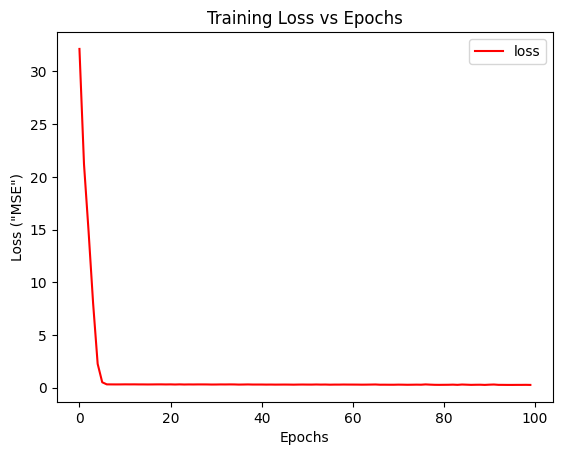

In [107]:

data, train_data, test_data, country_name = get_country('Argentina')
dataset = generate_training_data(train_data)
model, history = build_model(dataset, 100)
history.plot(color = 'red', xlabel = 'Epochs', ylabel = 'Loss ("MSE")', title = 'Training Loss vs Epochs')

In [108]:
train_input, train_time =  generate_testing_data(train_data)
test_input, test_time =  generate_testing_data(test_data)

train_prediction = model.predict(train_input)
train_prediction = pd.Series(train_prediction[:,0], index = train_time[2:]) #2001 - 2018

test_prediction = model.predict(test_input)
test_prediction = test_prediction[-3:]
test_prediction = pd.Series(test_prediction[:,0], index = test_time[-3:]) #2019 - 2021

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\Balogun Oladimeji\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


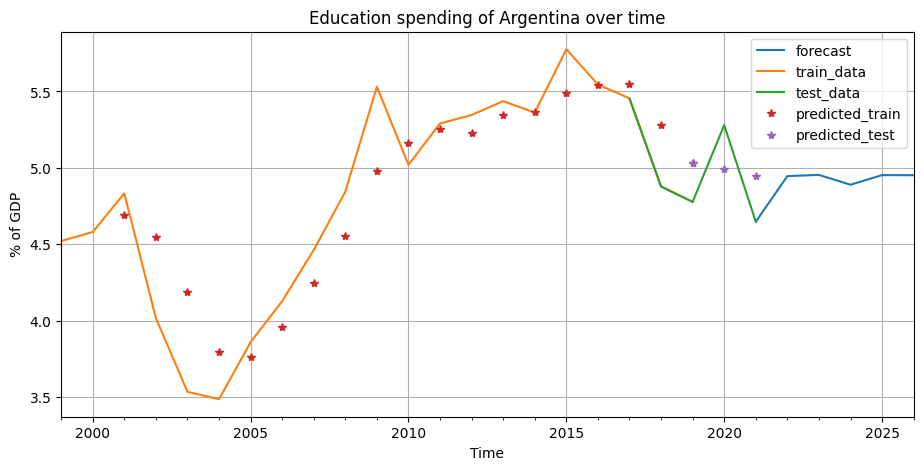

In [110]:
_, ax = plt.subplots( figsize = (11,5), sharex = True)
visualize_timeseries((forecast(model, 5, data), train_data, test_data, train_prediction, test_prediction), ax = ax, title = f'Education spending of {country_name} over time', style = ('-', '-', '-', '*', '*'), labels = ['forecast', 'train_data','test_data', 'predicted_train', 'predicted_test']);

In [114]:
mse = tf.keras.losses.MeanSquaredError()

print(mse(test_prediction.values, test_data.values[2:][:, 0]).numpy())
print(mse(test_prediction.values, test_data.values[2:][:, 0]).numpy())

0.07830837
0.07830837


In [115]:
model_dict = dict()
for country in list_of_countries:
    data, train_data, test_data, country_name = get_country(country)
    dataset = generate_training_data(train_data)
    model, history = build_model(dataset, 100)
    model_dict[country_name] = model

C:\Users\Balogun Oladimeji\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 27.9149
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.2296 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1544 
Epoch 4/100


C:\Users\Balogun Oladimeji\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.8206 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7039
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3183 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8966 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0069 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4953 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7498 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3266 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2620 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2714 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2354 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2050 
Epoch 16/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2454 
Epoch 17/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1912 
Epoch 18/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.176

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.3869
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8288 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1968 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5650 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0376 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7278 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2147 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0571 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0547 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0566 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.3848
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2502 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1311 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2584 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0792 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3872 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6587 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2842 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2112 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1269 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1028 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1065 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1273 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1189 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3318
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9845 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9756 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7685 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5473 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2828 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1318 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3893 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1046 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0426 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0399 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 229.6695
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156.3535 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.3655 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.8290 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.1293 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9771 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5526 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9048 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5705 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9026 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8243 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2469 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4552 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.5263
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.2252
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9089 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1404 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1990 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1442     
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2051 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1974 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.2153
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2143 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.1518
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1781 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2363 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2143 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.2591
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 91

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.2782
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6002 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.5552 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5276 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1327 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 1.0738
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2725 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0546 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0569 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0372 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0481     
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375     
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374     
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0392 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 67.1324
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47.2215 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.1060 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.8608 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.8621 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.1258 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.4736 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5425  
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 6.0793
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 3.8089
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9305 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7726 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.4137
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1884     
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 26.6340
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.9124 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.6139 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3488 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 20.3119
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9389 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2488 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.2161 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.3417 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9970 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5488 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8644 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8192 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3613 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27.3175
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.0436 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.3707 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0633 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2329 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6096 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4227 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1277 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1060 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0615 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0756     
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0652     
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0852     
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0805 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 97.3010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.5656 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.2866 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.1801 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.1729 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.0139 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3184 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9935 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.9419 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9235  
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1779 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7353 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3200 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1780 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9598
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4728 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6399 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3010 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4778 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1311 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0140 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104     
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5053
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9271 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7299 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5227 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6926 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3045 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7361 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2055 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1533 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0520 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1032 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1211 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1301 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1044 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.8694
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.6898 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3097 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5154 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1239  
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3636 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9614 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2975 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7835 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7568 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5734 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5280 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4764 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6013
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0014 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5131 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0593 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0215 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0346     
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.0303   
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195     
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.0289   
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 100.7438
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84.8268 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.3592 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.1342 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.2724 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.5702 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.0891 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9179 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.5030 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 10.9926
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9463 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0483 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 2.0275
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9531 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18.8331
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 13.1242
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3476  
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 6.0551
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7271 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0151 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 1.0402
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3811 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.1761
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.0896
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0705     
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0623 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0949 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0721 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 28.6269
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.5862 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 12.3318
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0938 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6221 
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.1040
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1648 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.1275
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1301 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1405 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0860 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0966 
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0816 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1261 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3549
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8890 
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1112 
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8737 
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.3182
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2211 
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2515 
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1895 
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1824 
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2503 
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2233 
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.2471
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2426 
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1763 
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

3/3 [==============================] - 0s 20ms/step


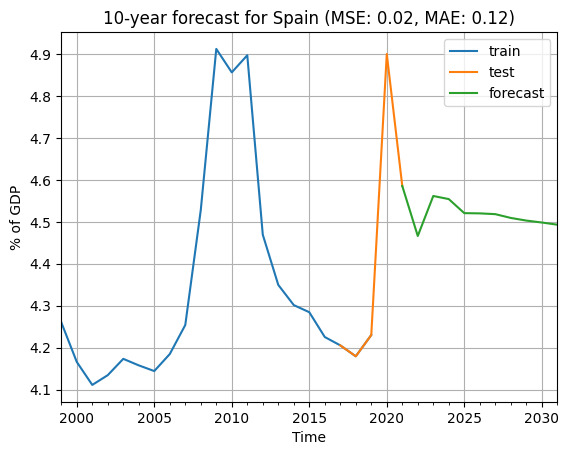

      Forecasts
2022   4.466209
2023   4.561520
2024   4.554130
2025   4.520639
2026   4.520084
2027   4.518250
2028   4.509214
2029   4.502951
2030   4.498333
2031   4.493138


In [282]:
plot_forecast('Spain', 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Balogun Oladimeji\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


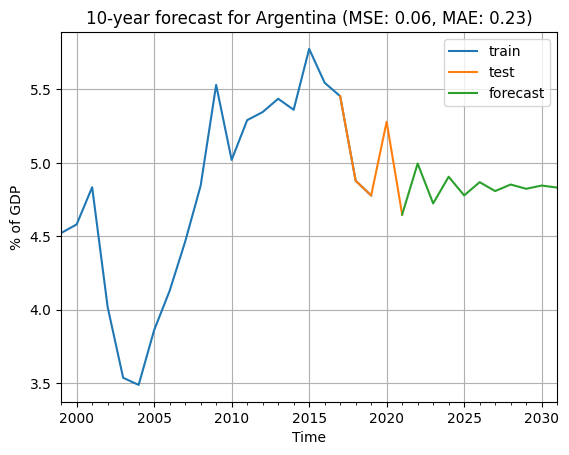

      Forecasts
2022   4.994896
2023   4.723224
2024   4.905096
2025   4.777727
2026   4.868295
2027   4.807348
2028   4.852083
2029   4.822906
2030   4.845075
2031   4.831212


In [116]:
plot_forecast("Argentina", 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\Balogun Oladimeji\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


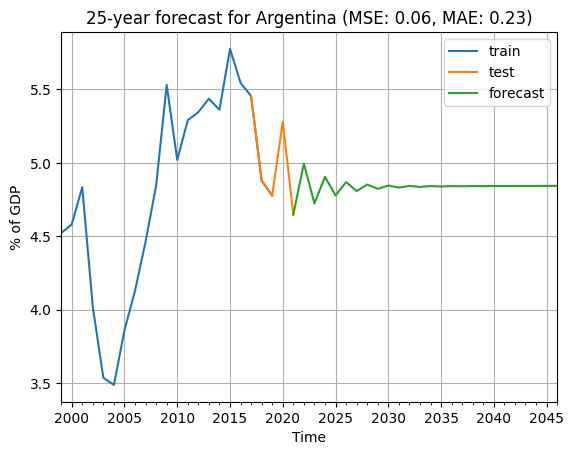

      Forecasts
2022   4.994896
2023   4.723224
2024   4.905096
2025   4.777727
2026   4.868295
2027   4.807348
2028   4.852083
2029   4.822906
2030   4.845075
2031   4.831212
2032   4.842293
2033   4.835801
2034   4.841418
2035   4.838454
2036   4.841360
2037   4.840068
2038   4.841615
2039   4.841103
2040   4.841959
2041   4.841799
2042   4.842293
2043   4.842285
2044   4.842586
2045   4.842636
2046   4.842829


In [118]:
plot_forecast("Argentina", 25)